## Set Up
Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from keras import models
from keras import layers
from keras import initializers

Using TensorFlow backend.


### Data generation

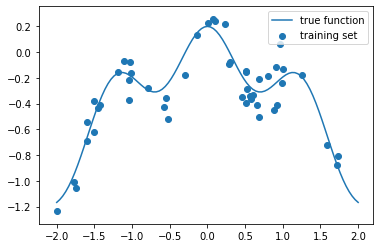

In [2]:
# set seed for reproducibility
np.random.seed(1)

def true_f_ex1(x, a, b):
  return(a*np.cos(5*x) + b*np.square(x))

def sim_data_ex1(n, a, b, sd, seed):
  '''
  A function to randomly generate data with a linear decision boundary
  
  Arguments:
   - n: integer sample size
  
  Return:
   - (x, y) tuple.  x is a numpy array of shape (n, 2) with feature values;
     y is a numpy array of shape (n, 1) with responses (0 or 1)
  '''
  np.random.seed(seed)

  # generate x, n by 1 matrix with observations in rows
  x = 4 * np.random.random((n, 1)) - 2

  # generate y
  y = true_f_ex1(x, a, b) + np.random.standard_normal((n, 1)) * sd

  return((x, y))

# generate training data and plot it
a = 0.2
b = -0.25
sd = 0.15
train_x, train_y = sim_data_ex1(n = 50, a = a, b = b, sd = sd, seed = 986)
val_x, val_y = sim_data_ex1(n = 1000, a = a, b = b, sd = sd, seed = 6315)

# true_function_values
x_grid = np.linspace(-2.0, 2.0, num = 101)
x_grid = x_grid.reshape(1, x_grid.shape[0])
true_f = true_f_ex1(x_grid[0, :], a, b)

# make a plot
plt.plot(x_grid[0, :], true_f, label = "true function")
plt.scatter(train_x[:, 0], train_y[:, 0], label = "training set")
plt.legend(loc = "upper right")
plt.show()

### Utility functions

First function fits a neural network model with specified number of layers and units, relu activations in all hidden layers, and an output layer with one unit and linear activation

Second function plots the activation outputs of all units, by layer.

In [0]:
from keras import backend as K

def fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds):
  model = models.Sequential()

  # add hidden layers
  input_units = [1] + hidden_units
  for (num_units, input_units, b_init_seed, w_init_seed) in zip(hidden_units, input_units, b_init_seeds, w_init_seeds):
    b_initializer = initializers.RandomNormal(seed=b_init_seed)
    w_initializer = initializers.RandomNormal(seed=w_init_seed)
    model.add(layers.Dense(num_units,
        activation = 'relu',
        input_shape = (input_units,),
        bias_initializer = b_initializer,
        kernel_initializer = w_initializer))
  
  # add output layer
  b_initializer = initializers.RandomNormal(seed=b_init_seeds[-1])
  w_initializer = initializers.RandomNormal(seed=w_init_seeds[-1])
  model.add(layers.Dense(1,
      activation = 'linear',
      bias_initializer = b_initializer,
      kernel_initializer = w_initializer))

  # compile and fit model
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  model.fit(train_x, train_y,
    validation_data = (val_x, val_y),
    epochs = 1000,
    batch_size = train_x.shape[0],
    verbose = 0)
  
  return(model)



def fit_model_linear_g_ex1(hidden_units, b_init_seeds, w_init_seeds):
  model = models.Sequential()

  # add hidden layers
  input_units = [1] + hidden_units
  for (num_units, input_units, b_init_seed, w_init_seed) in zip(hidden_units, input_units, b_init_seeds, w_init_seeds):
    b_initializer = initializers.RandomNormal(seed=b_init_seed)
    w_initializer = initializers.RandomNormal(seed=w_init_seed)
    model.add(layers.Dense(num_units,
        activation = 'linear',
        input_shape = (input_units,),
        bias_initializer = b_initializer,
        kernel_initializer = w_initializer))
  
  # add output layer
  b_initializer = initializers.RandomNormal(seed=b_init_seeds[-1])
  w_initializer = initializers.RandomNormal(seed=w_init_seeds[-1])
  model.add(layers.Dense(1,
      activation = 'linear',
      bias_initializer = b_initializer,
      kernel_initializer = w_initializer))

  # compile and fit model
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  model.fit(train_x, train_y,
    validation_data = (val_x, val_y),
    epochs = 1000,
    batch_size = train_x.shape[0],
    verbose = 0)
  
  return(model)



def plot_layers(model, hidden_legend, include_hidden = True, figsize=(10, 8)):
  if include_hidden:
    num_model_layers = len(model.layers)
  else:
    num_model_layers = 1
  
  fig, axs = plt.subplots(num_model_layers, 1, figsize=figsize)

  # Hidden layers
  if include_hidden:
    for i in range(num_model_layers - 1):
      get_layer_a = K.function([model.layers[0].input], [model.layers[i].output])
      a = get_layer_a([x_grid.T])[0].T

      (w, b) = model.layers[i].get_weights()
      b = b.reshape(b.shape[0], 1)

      for j in range(b.shape[0]):
        axs[i].plot(x_grid[0, :], a[j, :], label = "a" + str(j+1))
      
      if hidden_legend:
        axs[i].legend(ncol = 5)
      
    last_ax = axs[-1]
  else:
    last_ax = axs
  
  # Output layer
  a_output = model.predict(x_grid.T)

  last_ax.plot(x_grid[0, :], true_f, label = "true function")
  last_ax.plot(x_grid[0, :], a_output, label = "estimated function")
  last_ax.scatter(train_x[:, 0], train_y[:, 0], label = "training set")

  plt.show()



def plot_layer_activations_facetted(model, layer_to_plot):
  fig, axs = plt.subplots(8, 4, figsize=(16, 12))

  # Last hidden layer activations, split up
  get_layer_a = K.function([model.layers[0].input], [model.layers[layer_to_plot].output])
  (w, b) = model.layers[layer_to_plot].get_weights()
  b = b.reshape(b.shape[0], 1)

  a = get_layer_a([x_grid.T])[0].T

  for i in range(32):
    plot_row = i % 8
    plot_col = i // 8
    for j in range(32):
      axs[plot_row, plot_col].plot(x_grid[0, :], a[j + i*32, :], label = "a" + str(j+i*32+1))

  plt.show()



def plot_decision_boundary(model_fit, preprocess_x_fn, x1lim, x2lim, gridlen, train_x, train_y):
    '''
    Plot decision boundaries for a Keras model fit with 2 quantitative inputs
    
    Arugments:
     - model_fit: keras model fit
     - preprocess_x_fn: function to preprocess x
     - x1lim: tuple of lower and upper limits for x1
     - x2lim: tuple of lower and upper limits for x2
     - gridlen: how many values of x1 and x2 for which to obtain predictions
     - train_x: n by 2 array of x values for training set
     - train_y: n by 1 array of y values for training set
    '''
    dx1 = (x1lim[1] - x1lim[0])/gridlen
    dx2 = (x2lim[1] - x2lim[0])/gridlen
    background_x0, background_x1 = np.mgrid[slice(x1lim[0], x1lim[1] + dx1, dx1), slice(x2lim[0], x2lim[1] + dx2, dx2)]
    background_x0_long = background_x0[0:gridlen,0:gridlen].reshape((gridlen**2, 1))
    background_x1_long = background_x1[0:gridlen,0:gridlen].reshape((gridlen**2, 1))
    background_x = np.concatenate((background_x0_long, background_x1_long), axis = 1)
    if preprocess_x_fn is not None:
        background_x = preprocess_x_fn(background_x)
    
    yhat_long = (model_fit.predict(background_x) > 0.5)
    yhat = yhat_long.reshape((gridlen, gridlen))

    fig, ax = plt.subplots()
    im = ax.pcolormesh(background_x0, background_x1, yhat, norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'), alpha = 0.2, edgecolors = 'none', antialiased = True)
    im = ax.scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 0], norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'))
    plt.show()

### One hidden layer, 16 units per layer, relu activation




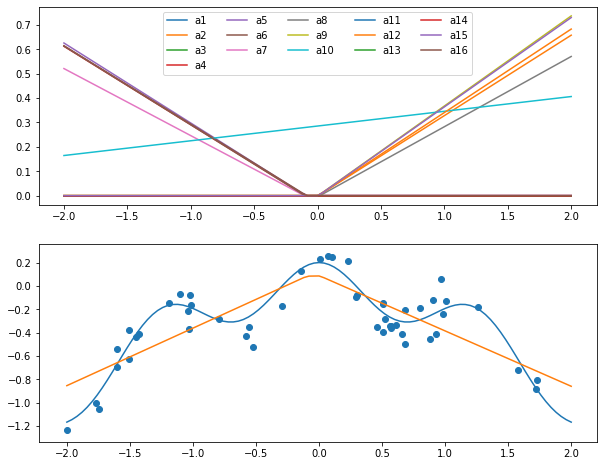

In [0]:
hidden_units = [16]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_1layer = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_1layer, hidden_legend=True)

### Four hidden layers, 16 units per layer, relu activation

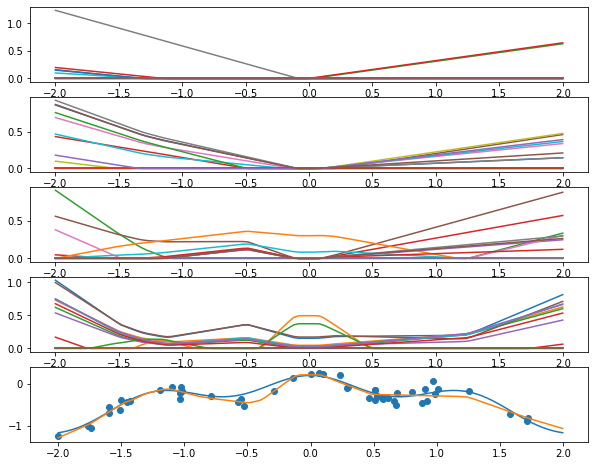

In [6]:
hidden_units = [16, 16, 16, 16]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_3layers = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_3layers, hidden_legend=False)

### Four hidden layers, 16 units per layer, linear activation

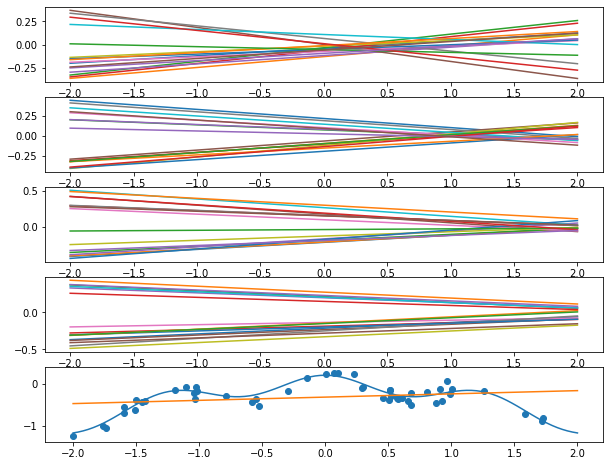

In [7]:
hidden_units = [16, 16, 16, 16]
np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_3layers = fit_model_linear_g_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_3layers, hidden_legend=False)